In [4]:
import os
os.getcwd()

'/Users/ashutosh.k/Documents/datascience/RetailMethodologies/MarketResponseModel'

####  Data 
Original Location: https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html (Helping CEOs Understand How Customers Interact With Advertising, Products, Brands, and Channels)

Updated and converted to usable format: https://gist.github.com/karamanbk/ef1a118592e2f7954e5bb582e09bdde3


## Building an Individual Level Response Model

#### Import Libraries First

In [31]:
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

import sklearn
#import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from itertools import cycle

plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])



#### Order Cluster Function

In [8]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [9]:
#import the data
df_data = pd.read_csv('data.csv')

In [10]:
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [12]:
df_data.offer.unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

#### Conversion column is the label to predict  
history: historical sales  
challen: Phone/Web/Multichannel  
offer: Discount, BoGo, No offer  

### Methodology
We will be building a binary classification model for scoring the conversion probability of all customers. For doing that, we are going to follow the steps below:  
* Building the uplift formula  
* Exploratory Data Analysis (EDA) & Feature Engineering
* Scoring the conversion probabilities
* Observing the results on the test set

#### Uplift Formula

Conversion Uplift: Conversion rate of test group - conversion rate of control group  
Order Uplift: Conversion uplift * number of converted customer in test group  
Revenue Uplift: Order Uplift * Average order $ value    

#### calc_uplift Function

In [18]:
def calc_uplift(df):
    ## Assigning $25 to the average order value
    avg_order_value = 25
    
    # Calculate conversion for each offer type
    base_conv = df[df.offer=='No Offer']['conversion'].mean()
    disc_conv = df[df.offer=='Discount']['conversion'].mean()
    bogo_conv = df[df.offer=='Buy One Get One']['conversion'].mean()
    
    # Calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv-base_conv
    bogo_conv_uplift = bogo_conv-base_conv
    
    # Calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.offer=='Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer=='Buy One Get One']['conversion'])
    
    # Calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
          
    print('-------------- \n')
    
    print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
    print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
    print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))
    
    

In [19]:
## Applying the function in our datafram
calc_uplift(df_data)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


Discount looks like a better option if we want to get more conversion. It brings 7.6% uptick compared to the customers who didn’t receive any offer. BOGO (Buy One Get One) has 4.5% uptick as well

## Phase 2: Identifying factors that drive this incremental change

#### EDA and Feature Engineering - Checking each feature one by one

#### Recency
Ideally the conversion should go down while recency goes up since inactive customers are less likely to buy again

Text(0.5, 1.0, 'Recency vs Conversion')

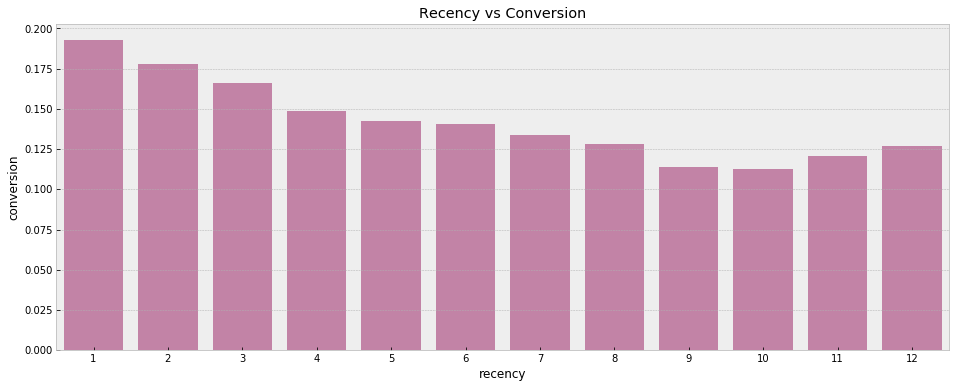

In [37]:
df_plot = df_data.groupby('recency').conversion.mean().reset_index()
df_plot.set_index('recency')
df_plot.head(10)
plt.figure(figsize=(16,6))
sns.barplot(x='recency',y='conversion',data=df_plot,color=next(color_cycle))
plt.title('Recency vs Conversion')

#### History

In [40]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_data[['history']])
df_data['history_cluster']=kmeans.predict(df_data[['history']])

df_data = order_cluster('history_cluster', 'history', df_data, True)

#Print how the clusters look like
df_data.groupby('history_cluster').agg({'history':['mean','min','max'], 'conversion':['count','mean']})


history                   conversion          
                        mean      min      max      count      mean
history_cluster                                                    
0                  73.907381    29.99   160.28      32278  0.122560
1                 246.434560   160.30   362.49      17955  0.160067
2                 478.085526   362.51   644.62       9105  0.180450
3                 810.504639   644.66  1110.09       3742  0.192678
4                1410.097750  1111.09  3345.93        920  0.217391

Text(0.5, 1.0, 'History vs Conversion')

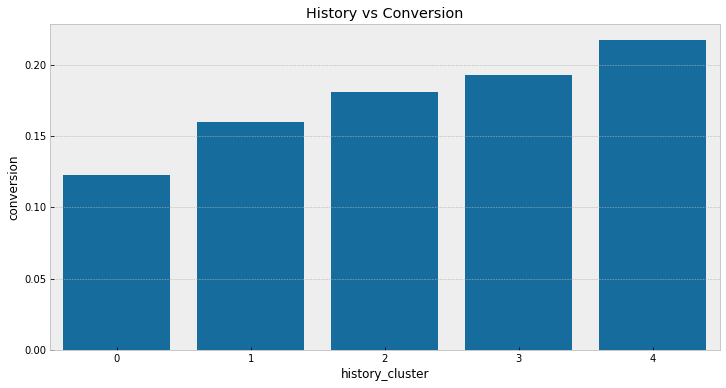

In [44]:
#### History vs conversion
df_plot = df_data.groupby('history_cluster').conversion.mean().reset_index()
df_plot.set_index('history_cluster')
df_plot.head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='history_cluster',y='conversion',data=df_plot,color=next(color_cycle))
plt.title('History vs Conversion')

#### Used Discount & BOGO

In [46]:
df_data.groupby(['used_discount','used_bogo','offer']).agg({'conversion':'mean'})

conversion
used_discount used_bogo offer                      
0             1         Buy One Get One    0.169794
                        Discount           0.166388
                        No Offer           0.095808
1             0         Buy One Get One    0.110892
                        Discount           0.168968
                        No Offer           0.099813
              1         Buy One Get One    0.251653
                        Discount           0.314993
                        No Offer           0.180549

Customers, who used both of the offers before, have the highest conversion rate.

#### ZIp Code

Text(0.5, 1.0, 'ZipCode vs Conversion')

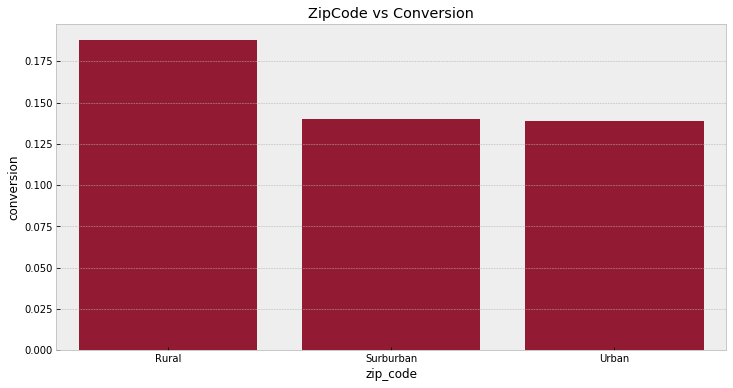

In [48]:
#### ZipCode vs conversion
df_plot = df_data.groupby('zip_code').conversion.mean().reset_index()
#df_plot.set_index('zip_code')
df_plot.head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='zip_code',y='conversion',data=df_plot,color=next(color_cycle))
plt.title('ZipCode vs Conversion')

Text(0.5, 1.0, 'Referral vs Conversion')

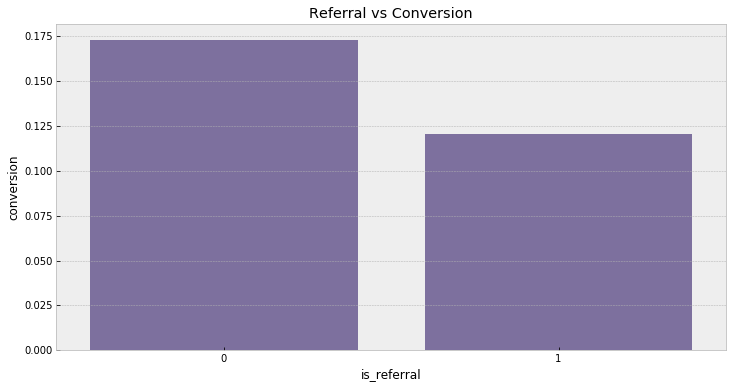

In [49]:
#Referral 
df_plot = df_data.groupby('is_referral').conversion.mean().reset_index()
#df_plot.set_index('zip_code')
df_plot.head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='is_referral',y='conversion',data=df_plot,color=next(color_cycle))
plt.title('Referral vs Conversion')

Text(0.5, 1.0, 'channel vs Conversion')

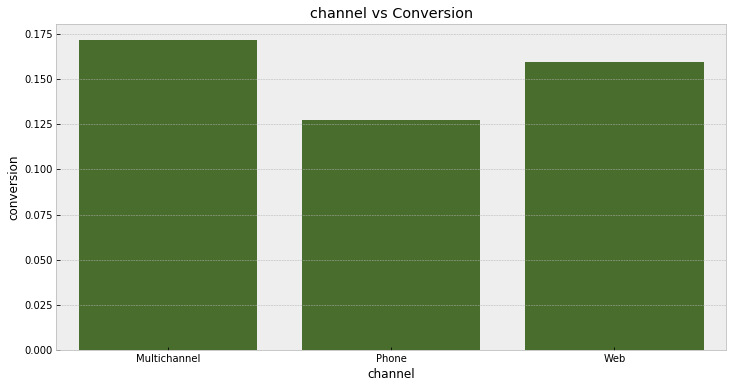

In [50]:
#Channel 
df_plot = df_data.groupby('channel').conversion.mean().reset_index()
#df_plot.set_index('zip_code')
df_plot.head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='channel',y='conversion',data=df_plot,color=next(color_cycle))
plt.title('channel vs Conversion')

Multichannel shows higher conversion rate as we expected. Using more than one channel is an indicator of high engagement.

Text(0.5, 1.0, 'offer vs Conversion')

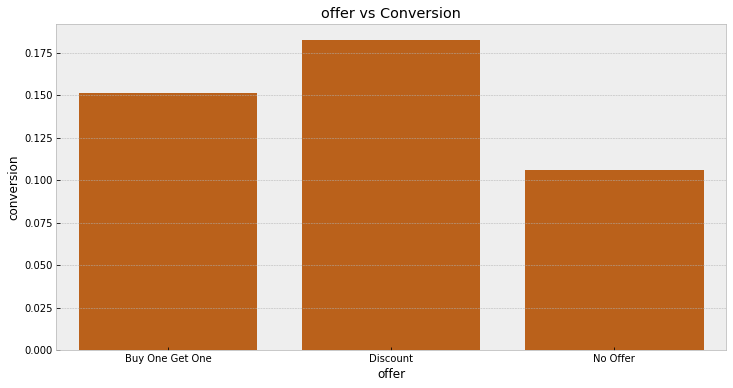

In [51]:
#Offer 
df_plot = df_data.groupby('offer').conversion.mean().reset_index()
df_plot.head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='offer',y='conversion',data=df_plot,color=next(color_cycle))
plt.title('offer vs Conversion')

### Feature Engineering - get_dummies

In [97]:
df_model = df_data.copy()
df_model = pd.get_dummies(df_model)

#### Scoring conversion probabilities

In [98]:
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,conversion,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer
0,10,142.44,1,0,0,0,0,0,1,0,0,1,0,1,0,0
1,2,45.34,1,0,0,0,0,0,0,1,0,0,1,1,0,0
2,6,134.83,0,1,0,1,0,0,1,0,0,1,0,1,0,0
3,9,46.42,0,1,0,0,0,0,0,1,0,1,0,1,0,0
4,10,32.84,0,1,1,0,0,0,0,1,0,0,1,1,0,0


In [111]:
#create feature set and labels
X = df_model.drop(['conversion'],axis=1)
y = df_model.conversion

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [113]:
from sklearn.linear_model import LogisticRegression


In [114]:
model = LogisticRegression()

In [115]:
model.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
X_test.shape

(12800, 15)

In [126]:
X_test.head()

,recency,history,used_discount,used_bogo,is_referral,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer,proba
32277,6,29.99,1,0,1,0,0,0,1,0,1,0,0,1,0,0.093555
12824,8,29.99,0,1,0,0,1,0,0,0,0,1,0,1,0,0.261342
20159,7,134.66,1,0,0,0,0,1,0,0,1,0,0,0,1,0.080282
41575,3,195.55,0,1,0,1,0,0,1,0,0,1,0,0,1,0.159573
10736,10,29.99,1,0,0,0,0,1,0,0,0,1,0,1,0,0.154617


In [118]:
pred = model.predict_proba(X_test)[:,1]

In [122]:
X_test['proba'] = pred

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [130]:
X_test['conversion'] = y_test

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The model has assigned probability of conversion form 0 to 1 for each customer

In [131]:
X_test.head()

,recency,history,used_discount,used_bogo,is_referral,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer,proba,conversion
32277,6,29.99,1,0,1,0,0,0,1,0,1,0,0,1,0,0.093555,0
12824,8,29.99,0,1,0,0,1,0,0,0,0,1,0,1,0,0.261342,0
20159,7,134.66,1,0,0,0,0,1,0,0,1,0,0,0,1,0.080282,0
41575,3,195.55,0,1,0,1,0,0,1,0,0,1,0,0,1,0.159573,0
10736,10,29.99,1,0,0,0,0,1,0,0,0,1,0,1,0,0.154617,0


Now we assume, the difference in the probability of discount, bogo and control group should be similar to conversion differences between them.
We need to use our test set to find it out.

In [132]:
real_disc_uptick = len(X_test)*(X_test[X_test['offer_Discount'] == 1].conversion.mean() - X_test[X_test['offer_No Offer'] == 1].conversion.mean())
pred_disc_uptick = len(X_test)*(X_test[X_test['offer_Discount'] == 1].proba.mean() - X_test[X_test['offer_No Offer'] == 1].proba.mean())

In [133]:
print("Real Discount Uptick - Order: {}, Revenue: {}".format(real_disc_uptick, real_disc_uptick*25))
print("Predicted Discount Uptick - Order: {}, Revenue: {}".format(pred_disc_uptick, pred_disc_uptick*25))


Real Discount Uptick - Order: 911.7049280910762, Revenue: 22792.623202276907
Predicted Discount Uptick - Order: 968.4324436996221, Revenue: 24210.811092490552


The results are pretty good. The real order uptick was 966 and the model predicted it as 948 (1.8% error).  
Revenue uptick prediction comparison: 24150 vs 23700.  
We need to check if the results are good for BOGO as well  

In [134]:
real_bogo_uptick = len(X_test)*(X_test[X_test['offer_Buy One Get One'] == 1].conversion.mean() - X_test[X_test['offer_No Offer'] == 1].conversion.mean())
pred_bogo_uptick = len(X_test)*(X_test[X_test['offer_Buy One Get One'] == 1].proba.mean() - X_test[X_test['offer_No Offer'] == 1].proba.mean())

In [135]:
print("Real Discount Uptick - Order: {}, Revenue: {}".format(real_bogo_uptick, real_bogo_uptick*25))
print("Predicted Discount Uptick - Order: {}, Revenue: {}".format(pred_bogo_uptick, pred_bogo_uptick*25))

Real Discount Uptick - Order: 497.4114165117516, Revenue: 12435.28541279379
Predicted Discount Uptick - Order: 590.9390147022417, Revenue: 14773.475367556042


Promising results for BOGO:  
Order uptick - real vs predicted: 563 vs 595  
Revenue uptick — real vs predicted: 14075 vs 14875  
The error rate is around 5.6%. The model can benefit from improving the prediction scores on BOGO offer type.  
Calculating conversion probabilities help us a lot in different areas as well. We have predicted the return of the different types of offers but it can help us to find out who to target for maximizing the uplift as well.  

#### Next: Uplift Model